In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, skewnorm, pearsonr
from joblib import Parallel, delayed
import time
from twoprocess import simulate_population_batch,generate_synthetic_periods_from_csv
from config import CONFIG

# ==============================================================================
# 1. OPTIMIZER CLASS (NUMBA ACCELERATED)
# ==============================================================================

class FastGridOptimizer:
    def __init__(self, n_sim=400, n_cycles=15, start_day=7):
        self.n_sim = n_sim
        self.start_day = start_day
        
        # Optimization Targets
        self.target_skew = 0.6
        self.target_median = 4.6
        self.target_duration = 7.5
        
        # Pre-generate Population Arrays (Once for the whole grid search)
        self._generate_population()

    def _generate_population(self):
        """
        Generates the biological parameters for the entire population as numpy arrays.
        This ensures every grid point tests the EXACT same agents (reducing noise).
        """
        np.random.seed(42) # Fixed seed for reproducibility
        d_params = CONFIG['dist_params']
        bp = CONFIG['bio_params']
        
        # 1. Periods (Use your synthetic generator or a simple placeholder)
        # For speed in this example, I'm using a SkewNorm approx, 
        # but you should use your 'generate_synthetic_periods' if you want full accuracy.
        self.periods = generate_synthetic_periods_from_csv(CONFIG['csv_path'], target_n= self.n_sim, bootstrap_iters=1000, seed=1)
        
        # 2. Other Params
        self.xis = skewnorm.rvs(a=d_params['xis_a'], loc=d_params['xis_loc'], scale=d_params['xis_scale'], size=self.n_sim)
        self.mus = skewnorm.rvs(a=d_params['mu_a'], loc=d_params['mu_loc'], scale=d_params['mu_scale'], size=self.n_sim)
        self.sigmas = np.repeat(bp['sigma'], self.n_sim)
        
        # Shuffle to break any correlation artifacts
        np.random.shuffle(self.periods)

    def evaluate_grid_point(self, Hu0, a):
        """
        Evaluates a single (Hu0, a) pair using the Numba Batch Simulator.
        """
        bp = CONFIG['bio_params']
        
        # --- FAST BATCH SIMULATION ---
        # Runs n_sim agents in parallel C-code
        results = simulate_population_batch(
            n_agents=self.n_sim,
            duration=CONFIG['duration'],
            dt=CONFIG['dt'],
            periods=self.periods,
            xis=self.xis,
            mus=self.mus,
            sigmas=self.sigmas,
            Hu0=Hu0,
            Hl0=bp['Hl0'],
            K=bp['K'],
            a=a,
            end=CONFIG['end'],
            start=CONFIG['start'],
            lag=bp['lag'],
            threshold=CONFIG.get('threshold', 0),
            alpha=bp['alpha'],
            start_day_analysis=CONFIG['start_day'],
            end_day_analysis= CONFIG['end_day']
        )
        
        # Extract columns: [Chronotype, Duration]
        chronos = results[:, 0]
        durations = results[:, 1]
        swperiod = results[:, 2] 
        
        # Filter NaNs (agents that didn't wake/sleep properly)
        mask_valid = ~np.isnan(chronos)
        clean_c = chronos[mask_valid]
        clean_d = durations[mask_valid]
        clean_swp = swperiod[mask_valid]
        clean_p = self.periods[mask_valid]
        
        if len(clean_c) < 10: 
            return {'Hu0': Hu0, 'a': a, 'error': 9999, 'median': np.nan}

        # --- OUTLIER REMOVAL (IQR) ---
        q1 = np.percentile(clean_c, 0)
        q3 = np.percentile(clean_c, 99.8)
        mask_outlier = (clean_c >= q1) & (clean_c <= q3 )
        
        final_c = clean_c[mask_outlier]
        final_d = clean_d[mask_outlier]
        final_p = clean_p[mask_outlier]
        final_swp = clean_swp[mask_outlier]
        
        if len(final_c) < 10: 
            return {'Hu0': Hu0, 'a': a, 'error': 9999, 'median': np.nan}

        # --- CALCULATE METRICS ---
        sim_skew = skew(final_c)
        sim_median = np.median(final_c)
        sim_duration = np.mean(final_d)
        sim_swp = np.mean(final_swp)
        # Calculate Error
        error = 0
        error += (sim_skew - self.target_skew) ** 2
        error += (sim_median - self.target_median) ** 2
        error += (sim_duration - self.target_duration) ** 2
        
        # Optional: Calculate R-value just for logging
        r_val, p_val = pearsonr(final_p, final_c) if len(final_c) > 2 else (0, 1)

        return {
            'Hu0': Hu0, 
            'a': a, 
            'error': error, 
            'skew': sim_skew, 
            'median': sim_median,
            'duration': sim_duration,
            'swp': sim_swp,
            'r_value': r_val,
            'p_value': p_val
        }

# ==============================================================================
# 2. RUN GRID SEARCH
# ==============================================================================

# Define Grid Range
hu0_values = np.linspace(0.5, 0.9, 51)  # Example range
a_values = np.linspace(0,0.2,21)    # Example range

optimizer = FastGridOptimizer(n_sim=400)

print(f"Starting Grid Search: {len(hu0_values) * len(a_values)} combinations...")
start_time = time.time()

# PARALLEL EXECUTION
# We use n_jobs=-1 to use all cores. 
# Since 'simulate_population_batch' is also parallel, there might be contention.
# Best practice: 
# 1. If N_AGENTS is huge (e.g., 10,000), set n_jobs=1 and let Numba handle parallelism.
# 2. If N_AGENTS is small (400) but Grid is large, set n_jobs=-1 here.
results = Parallel(n_jobs=8)(
    delayed(optimizer.evaluate_grid_point)(h, a) 
    for h in hu0_values 
    for a in a_values
)

df_results = pd.DataFrame(results)

print(f"Grid Search Complete in {time.time() - start_time:.2f} seconds.")


Starting Grid Search: 1071 combinations...
Grid Search Complete in 36.84 seconds.


In [ ]:
# df_results.to_csv('grid_search_results_parallel_swperiod.csv', index=False)

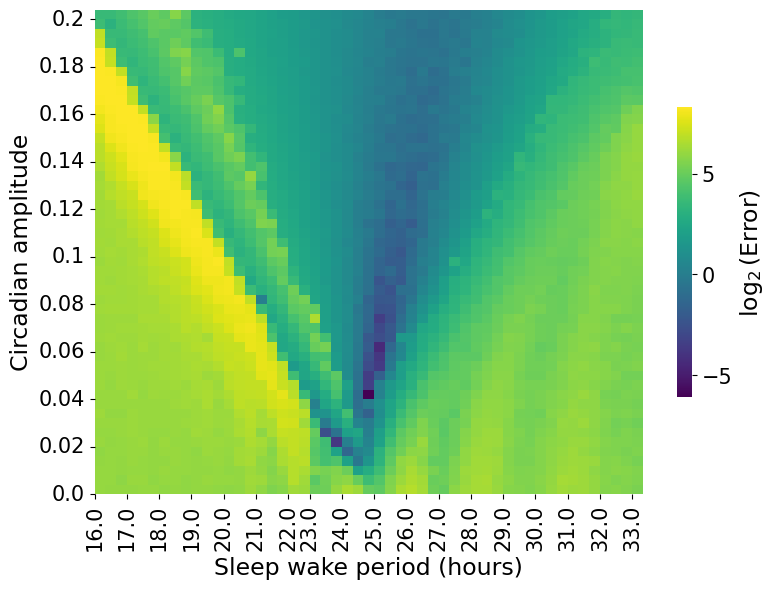

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, skewnorm, pearsonr
from joblib import Parallel, delayed
import time
from twoprocess import simulate_population_batch,generate_synthetic_periods_from_csv
from config import CONFIG
# ==============================================================================
# 3. PLOTTING THE ERROR LANDSCAPE
# ==============================================================================

df_results = pd.read_csv('grid_search_results_parallel_freeday.csv')
df = df_results.copy()
# Divide df['swp'] into arrays of length 51, replace with average, and put back
chunk_size = 51
swp_values = df['swp'].values

# # Divide into chunks and calculate average for each chunk
n_chunks = len(swp_values) // chunk_size
swp_averaged = np.array([])

for i in range(n_chunks):
    chunk = swp_values[i * chunk_size:(i + 1) * chunk_size]
    chunk_mean = np.mean(chunk)
    swp_averaged = np.concatenate([swp_averaged, np.repeat(chunk_mean, len(chunk))])

# # Put the averaged array back into the dataframe
df['swp'] = swp_averaged.round(3)
df['Hu0'] = df['Hu0'].round(3)
df['a'] = df['a'].round(3)
df['error'] = np.log2(df['error'])
swp_val = np.unique(np.round(swp_averaged,1)) 
tick_arr =[15.9,17,18,19.1,20.2,21.2,22.3,23,24,25,26,27.1,28.1,29.1,30.1,31,32,33]
ticks_loc = np.searchsorted(swp_val, tick_arr)
pivot_error = df.pivot(index='a', columns='swp', values='error')
plt.figure(figsize=(8,6))
ax = sns.heatmap(pivot_error, annot=False, cmap='viridis', cbar=True, cbar_kws={'shrink':0.6})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
cbar.set_ticks([-5,0,5])
cbar.set_label(r'$\log_2(\text{Error})$', fontsize=17)
plt.xticks(ticks = ticks_loc,labels = np.round(tick_arr,0),fontsize=15)
plt.yticks(np.arange(0, len(np.unique(df['a'])),5), labels=np.round(np.unique(df['a'])[::5],2), fontsize=15)
plt.xlabel("Sleep wake period (hours)", fontsize = 17)
plt.ylabel("Circadian amplitude", fontsize = 17)
plt.gca().invert_yaxis()
plt.tight_layout()
# plt.savefig("4A - heatmap_KLdiv.png", dpi = 300)
plt.show()

